## Carga de módulos

In [1]:
import warnings
import numpy as np
import pandas as pd
import missingno as msno
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from utilities.evaluation import ModelEvaluation
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

pd.set_option('float_format', '{:.2f}'.format)
warnings.filterwarnings(action='ignore')

## Carga de datos

In [2]:
churn = pd.read_csv('https://raw.githubusercontent.com/stivenlopezg/Diplomado-Python/master/data/Churn_Modelling.csv',
                    index_col=0)

for column in ['HasCrCard', 'IsActiveMember']:
    churn[column] = churn[column].map({1: 'Yes', 0: 'No'})

churn.sample(n=4)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
8203,15747647,Iadanza,589,Spain,Female,27,4,0.00,2,Yes,No,144181.48,0
5068,15602282,Kao,587,Germany,Female,45,8,134980.74,1,Yes,Yes,123309.57,1
4735,15591740,Fletcher,590,France,Female,54,4,0.00,2,Yes,Yes,93820.49,1
6419,15801924,Browne,754,Spain,Female,27,8,0.00,2,No,No,121821.16,0


In [3]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  object 
 10  IsActiveMember   10000 non-null  object 
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 1.1+ MB


In [4]:
# datos nulos

indices_cat = churn.sample(n=6, random_state=42).index
indices_num = churn.sample(n=4, random_state=123).index

churn.loc[indices_cat, 'Geography'] = np.nan
churn.loc[indices_num, 'EstimatedSalary'] = np.nan

In [5]:
churn.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          6
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    4
Exited             0
dtype: int64

<AxesSubplot:>

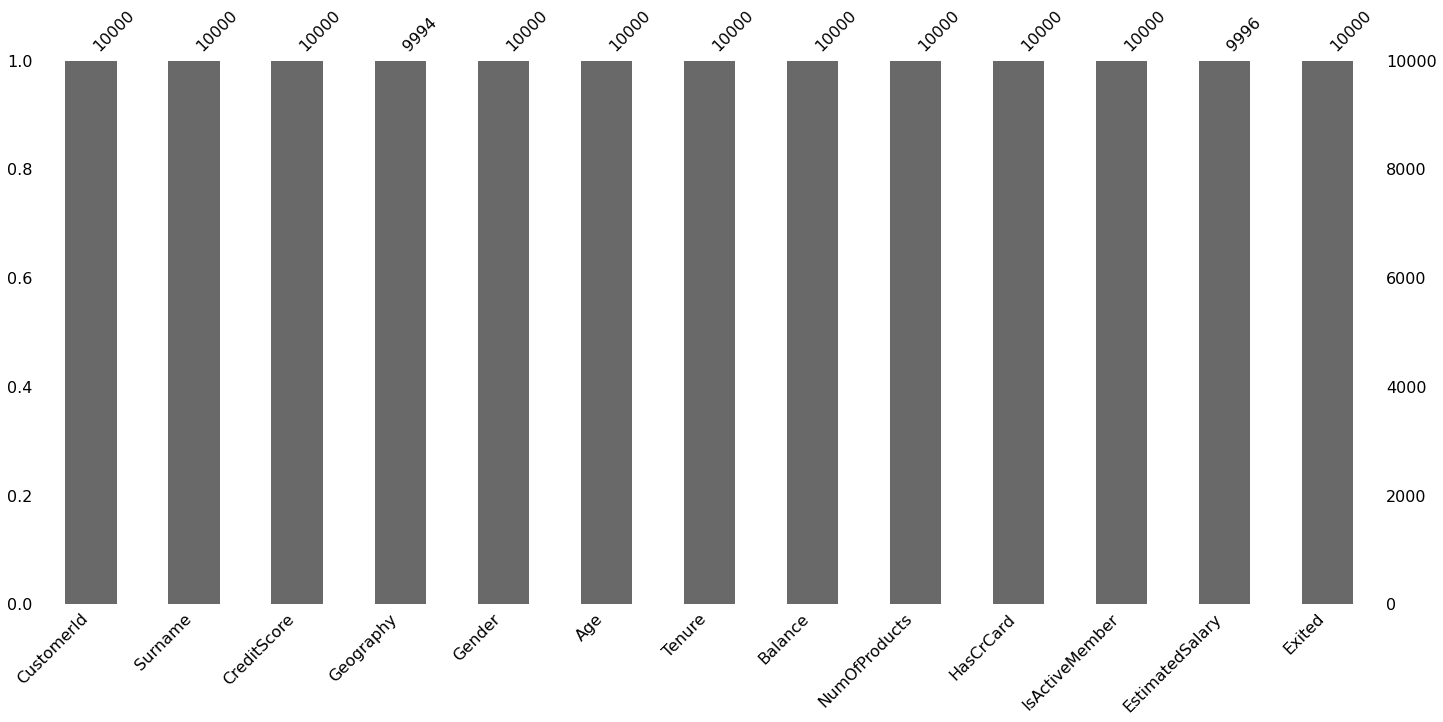

In [7]:
msno.bar(churn)

<AxesSubplot:>

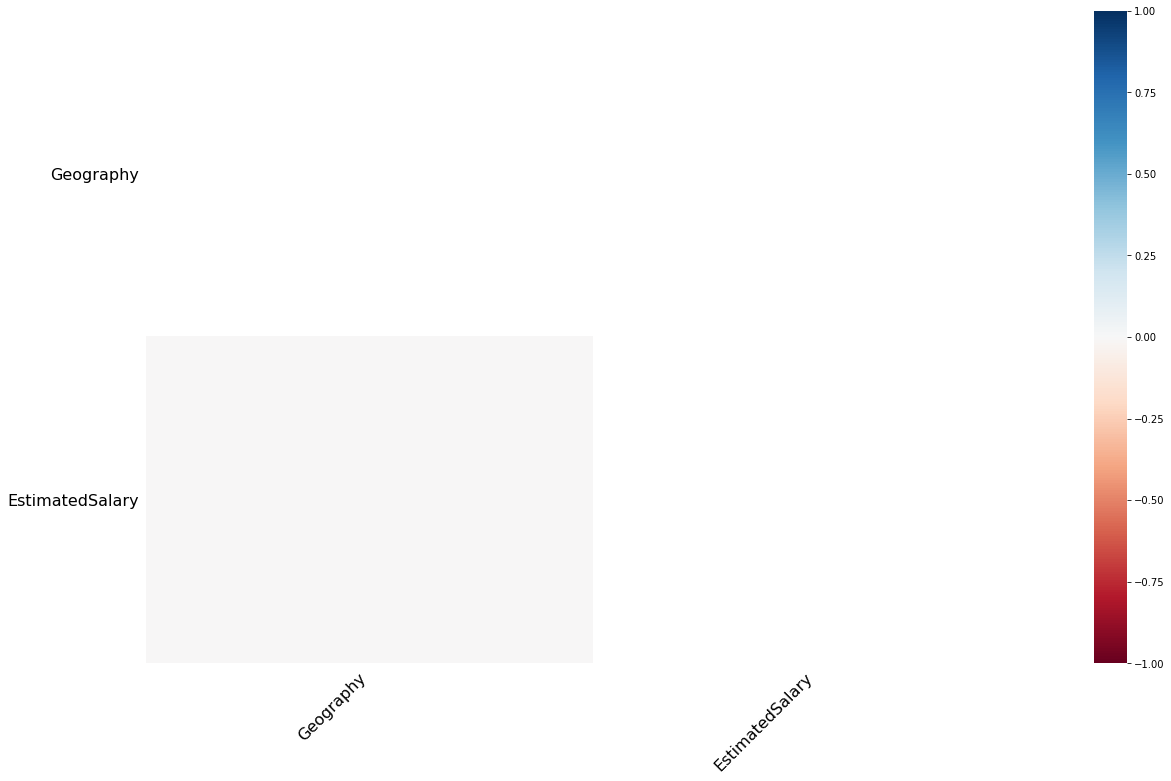

In [8]:
msno.heatmap(churn)

## Validación cruzada y elección del modelo

In [9]:
exited = churn.pop('Exited')

train_data, test_data, train_label, test_label = train_test_split(churn, exited,
                                                                  test_size=0.3,
                                                                  stratify=exited, random_state=42)

print(f'El set de entrenamiento tiene {train_data.shape[0]} observaciones, y {train_data.shape[1]} variables.')
print(f'El set de prueba tiene {test_data.shape[0]} observaciones, y {test_data.shape[1]} variables.')

El set de entrenamiento tiene 7000 observaciones, y 12 variables.
El set de prueba tiene 3000 observaciones, y 12 variables.


In [10]:
numerical_features = ['CreditScore', 'Age', 'Tenure',
                      'Balance', 'NumOfProducts', 'EstimatedSalary']

categorical_features = ['Gender', 'Geography', 'HasCrCard', 'IsActiveMember']

In [19]:
numeric_preprocessing = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                        ('scaler', StandardScaler())])

categoric_preprocessing = Pipeline(steps=[('cat_imputer', SimpleImputer(strategy='most_frequent')),
                                          ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))])

preprocessing = ColumnTransformer(transformers=[('numeric', numeric_preprocessing, numerical_features),
                                                ('categorical', categoric_preprocessing, categorical_features)],
                                  remainder='drop')

In [23]:
lr = Pipeline(steps=[('preprocessing', preprocessing),
                     ('logistic_regression', LogisticRegression(class_weight='balanced',
                                                                random_state=42, n_jobs=-1))])

dtree = Pipeline(steps=[('preprocessing', preprocessing),
                        ('dtree', DecisionTreeClassifier(class_weight='balanced',
                                                         random_state=42))])

## Validación cruzada y elección del modelo

In [24]:
roc = {}

roc['logistic_regression'] = cross_val_score(estimator=lr,
                                             X=train_data, y=train_label, scoring='roc_auc', cv=5, n_jobs=-1)
roc['decision_tree'] = cross_val_score(estimator=dtree,
                                       X=train_data, y=train_label, scoring='roc_auc', cv=5, n_jobs=-1)

In [26]:
roc = pd.DataFrame.from_dict(roc)
roc

,logistic_regression,decision_tree
0,0.74,0.66
1,0.76,0.68
2,0.78,0.67
3,0.74,0.68
4,0.76,0.66


<AxesSubplot:>

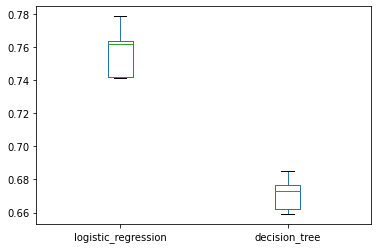

In [27]:
roc.plot(kind='box')

## Optimizar hiperparametros

In [31]:
set_config(display='diagram')

lr = Pipeline(steps=[('preprocessing', preprocessing),
                     ('logistic_regression', LogisticRegression(class_weight='balanced',
                                                                random_state=42, n_jobs=-1))])

lr.fit(train_data, train_label)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Gender', 'Geography',
                                                   'HasCrCard',
                                                   'IsActiveMember'])])),
                ('logistic_regression',
                 LogisticRegression(class_weight='balanced', n_jobs=-1,
                                    random_state=42))])

In [32]:
print(f'La exactitud en el set de entrenamiento es: {lr.score(train_data, train_label)}')

La exactitud en el set de entrenamiento es: 0.7037142857142857


In [33]:
evaluation = ModelEvaluation(observed=test_label, predicted=lr.predict(test_data))
evaluation.generate_report()

,precision,recall,f1-score,support
0,0.91,0.72,0.80,2389.00
1,0.40,0.73,0.51,611.00
accuracy,0.72,0.72,0.72,0.72
macro avg,0.65,0.72,0.66,3000.00
weighted avg,0.81,0.72,0.74,3000.00


In [35]:
evaluation.calculate_metrics()
evaluation.print_metrics()
evaluation.confusion_matrix()

El AUC es: 0.72
El accuracy es: 0.72
La precision es: 0.81
El recall es: 0.72
El F1 Score es: 0.74 



Predicted,0,1
Observed,,
0,0.72,0.28
1,0.27,0.73


In [36]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [37]:
params = {'logistic_regression__penalty': ['l1', 'l2'],
          'logistic_regression__fit_intercept': [True, False],
          'logistic_regression__class_weight': ['balanced', None]}

lr = Pipeline(steps=[('preprocessing', preprocessing),
                     ('logistic_regression', LogisticRegression(random_state=42, n_jobs=-1))])

lr_cv = GridSearchCV(estimator=lr, param_grid=params, scoring='roc_auc', n_jobs=-1, cv=5)

lr_cv.fit(train_data, train_label)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['CreditScore',
                                                                          'Age',
                                                                          'Tenure',
                                                                          'Balance',
                                                                          'NumOfProducts',
                                                                          'EstimatedSalary']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('cat_imputer',
                                                                                          SimpleImputer(strategy='most_freq...
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['Gender',
                                                                          'Geography',
                                                                          'HasCrCard',
                                                                          'IsActiveMember'])])),
                                       ('logistic_regression',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'logistic_regression__class_weight': ['balanced',
                                                               None],
                         'logistic_regression__fit_intercept': [True, False],
                         'logistic_regression__penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [38]:
lr_cv.best_params_

{'logistic_regression__class_weight': 'balanced',
 'logistic_regression__fit_intercept': False,
 'logistic_regression__penalty': 'l2'}

In [39]:
lr_cv.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Gender', 'Geography',
                                                   'HasCrCard',
                                                   'IsActiveMember'])])),
                ('logistic_regression',
                 LogisticRegression(class_weight='balanced',
                                    fit_intercept=False, n_jobs=-1,
                                    random_state=42))])

In [40]:
lr_cv.best_score_

0.7574748408356442

In [41]:
evaluation = ModelEvaluation(observed=test_label, predicted=lr_cv.predict(test_data))
evaluation.generate_report()

,precision,recall,f1-score,support
0,0.91,0.72,0.80,2389.00
1,0.40,0.73,0.51,611.00
accuracy,0.72,0.72,0.72,0.72
macro avg,0.65,0.72,0.66,3000.00
weighted avg,0.81,0.72,0.74,3000.00


In [42]:
evaluation.calculate_metrics()
evaluation.print_metrics()
evaluation.confusion_matrix()

El AUC es: 0.72
El accuracy es: 0.72
La precision es: 0.81
El recall es: 0.72
El F1 Score es: 0.74 



Predicted,0,1
Observed,,
0,0.72,0.28
1,0.27,0.73


In [43]:
params = {'logistic_regression__penalty': ['l1', 'l2'],
          'logistic_regression__fit_intercept': [True, False],
          'logistic_regression__class_weight': ['balanced', None]}

lr = Pipeline(steps=[('preprocessing', preprocessing),
                     ('logistic_regression', LogisticRegression(random_state=42, n_jobs=-1))])

lr_cv = RandomizedSearchCV(estimator=lr, param_distributions=params,
                           n_iter=4, scoring='roc_auc', n_jobs=-1, cv=5)

lr_cv.fit(train_data, train_label)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['CreditScore',
                                                                                'Age',
                                                                                'Tenure',
                                                                                'Balance',
                                                                                'NumOfProducts',
                                                                                'EstimatedSalary']),
                                                                              ('categorical',
                                                                               Pipeline(steps=[('cat_imputer',
                                                                                                SimpleImputer(strategy='mos...
                                                                                                              sparse=False))]),
                                                                               ['Gender',
                                                                                'Geography',
                                                                                'HasCrCard',
                                                                                'IsActiveMember'])])),
                                             ('logistic_regression',
                                              LogisticRegression(n_jobs=-1,
                                                                 random_state=42))]),
                   n_iter=4, n_jobs=-1,
                   param_distributions={'logistic_regression__class_weight': ['balanced',
                                                                              None],
                                        'logistic_regression__fit_intercept': [True,
                                                                               False],
                                        'logistic_regression__penalty': ['l1',
                                                                         'l2']},
                   scoring='roc_auc')

In [44]:
lr_cv.best_params_

{'logistic_regression__penalty': 'l2',
 'logistic_regression__fit_intercept': True,
 'logistic_regression__class_weight': None}

In [45]:
lr_cv.best_score_

0.7544958649890022

In [46]:
evaluation = ModelEvaluation(observed=test_label, predicted=lr_cv.predict(test_data))
evaluation.generate_report()

,precision,recall,f1-score,support
0,0.83,0.97,0.89,2389.00
1,0.63,0.20,0.30,611.00
accuracy,0.81,0.81,0.81,0.81
macro avg,0.73,0.58,0.60,3000.00
weighted avg,0.79,0.81,0.77,3000.00


In [47]:
evaluation.calculate_metrics()
evaluation.print_metrics()
evaluation.confusion_matrix()

El AUC es: 0.58
El accuracy es: 0.81
La precision es: 0.79
El recall es: 0.81
El F1 Score es: 0.77 



Predicted,0,1
Observed,,
0,0.97,0.03
1,0.80,0.20
